In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import volo
import torch
import torch.nn as nn
import torch.optim as opt
torch.set_printoptions(linewidth=120)
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
print(torch.__version__)

1.8.1+cu111


(600, 600, 3)

array([142.05081389, 142.05081389, 142.05081389])

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


Index(['id', 'Negative for Pneumonia', 'Typical Appearance',
       'Indeterminate Appearance', 'Atypical Appearance'],
      dtype='object')

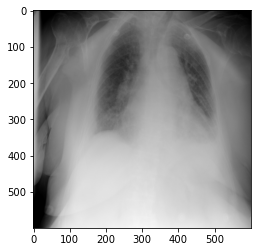

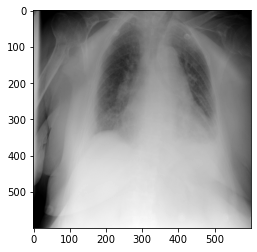

In [3]:
study_label = pd.read_csv('../archive/train_study_level.csv')
study_example = cv2.imread('../archive/study/00086460a852_study.png')
display(study_example.shape)
plt.imshow(study_example, cmap='gray')
display(np.mean(study_example, axis=(0,1)))
study_example = study_example[:, :, 0]
plt.figure()
plt.imshow(study_example, cmap='gray')
display(study_label.head())
display(study_label.columns)

In [4]:
paths = []
ids = study_label.id
labels = study_label.iloc[:, 1:].to_numpy()
for i in range(len(ids)):
    paths.append('../archive/study/{x}.png'.format(x = ids[i]))
paths = np.array(paths)
display(paths.shape, labels.shape)

(6054,)

(6054, 4)

In [5]:
'''
means = []
stds = []
for path in paths:
    temp = cv2.imread(path)[:, :, 1]
    means.append(np.mean(temp))
    stds.append(np.std(temp))
plt.hist(means)
'''

'\nmeans = []\nstds = []\nfor path in paths:\n    temp = cv2.imread(path)[:, :, 1]\n    means.append(np.mean(temp))\n    stds.append(np.std(temp))\nplt.hist(means)\n'

In [6]:
#plt.hist(stds)

In [9]:
class adding_bn(nn.Module):
    def __init__(self, n):
        super(adding_bn, self).__init__()
        self.bn = nn.BatchNorm2d(n)
        kwargs = { 
            'img_size': 448,
            'in_chans': 1,
            'num_classes': 4,
            'return_dense': False,
            'mix_token': False,
            'patch_size': 8,

        }
        self.model = volo.volo_d1(**kwargs)
        
    def forward(self, x):
        x = self.bn(x)
        return self.model(x)

In [10]:
model = adding_bn(1)
print(model)

adding_bn(
  (bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (model): VOLO(
    (patch_embed): PatchEmbed(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU(inplace=True)
      )
      (proj): Conv2d(64, 192, kernel_size=(4, 4), stride=(4, 4))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (network): ModuleList(
      (0): Sequential(
      

In [5]:
class classification(nn.Module):
    def __init__(self, paths, labels, aug=False):
        self.paths = paths
        self.labels = labels
        self.aug = aug
        self.example = []
    
    def __getitem__(self, idx):
            path = self.paths[idx]
            img = cv2.imread(path)[:, :, 0]
            img = (img - np.mean(img))/np.std(img)
            #img = img/np.mean(img)
            img = cv2.resize(img, (448, 448))
            x = torch.from_numpy(np.array(img)).view((1, 448, 448))
            x = x.float()
            y = np.argmax(self.labels[idx])
            y = torch.tensor(y)
            return x, y
        
    def __len__(self):
        return len(self.paths)
    
    def get(self):
        return self.example

In [6]:
dataset = classification(paths[:500], labels[:500])
print(len(dataset))
train_set, val_set = torch.utils.data.random_split(dataset, [400, 100])

500


In [7]:
class Trainer():
    def __init__(self,model,train_set,test_set,opts):
        self.model = model  # neural net
        # device agnostic code snippet
        self.device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
        print(self.device)
        self.model.to(self.device)
        
        self.epochs = opts['epochs']
        self.optimizer = torch.optim.Adam(model.parameters(), opts['lr']) # optimizer method for gradient descent
        self.criterion = torch.nn.CrossEntropyLoss()                      # loss function
        self.train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                                        batch_size=opts['batch_size'],
                                                        shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                                       batch_size=opts['batch_size'],
                                                       shuffle=False)
        self.tb = SummaryWriter()
        self.example = []
        self.bn = nn.BatchNorm2d(1).to(self.device)
        
    def train(self):
        for epoch in range(self.epochs):
            self.model.train() #put model in training mode
            self.tr_loss = []
            for i, (data,labels) in tqdm(enumerate(self.train_loader),
                                                   total = len(self.train_loader)):
                if i % 10 == 0:
                    self.example.append(data.detach().cpu().numpy())
                data, labels = data.to(self.device),labels.to(self.device)
                data = self.bn(data)
                self.optimizer.zero_grad()  
                outputs = self.model(data)   
                loss = self.criterion(outputs, labels) 
                loss.backward()                        
                self.optimizer.step()                  
                self.tr_loss.append(loss.item())     
            self.tb.add_scalar("Train Loss", np.mean(self.tr_loss), epoch)
            self.test(epoch) # run through the validation set
            
        self.tb.close()
            
    def test(self,epoch):
            
            self.model.eval()    # puts model in eval mode - not necessary for this demo but good to know
            self.test_loss = []
            self.test_accuracy = []
            
            for i, (data, labels) in enumerate(self.test_loader):
                
                data, labels = data.to(self.device),labels.to(self.device)
                data = self.bn(data)
                with torch.no_grad():
                    outputs = self.model(data)
                
                _, predicted = torch.max(outputs.data, 1)
                print(predicted)
                loss = self.criterion(outputs, labels)
                self.test_loss.append(loss.item())
                
                self.test_accuracy.append((predicted == labels).sum().item() / predicted.size(0))
            
            print('epoch: {}, train loss: {}, test loss: {}, test accuracy: {}'.format( 
                  epoch+1, np.mean(self.tr_loss), np.mean(self.test_loss), np.mean(self.test_accuracy)))
            self.tb.add_scalar("Val Acc", np.mean(self.test_accuracy), epoch)
            self.tb.add_scalar("Val Loss", np.mean(self.test_loss), epoch)
    def get(self):
        return self.example

In [8]:
opts = {
    'lr': 1e-4,
    'epochs': 10,
    'batch_size': 10
}
train = Trainer(model, train_set, val_set, opts)

cuda:1


In [9]:
train.train()


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')
epoch: 1, train loss: 1.3177970603108407, test loss: 1.2062648057937622, test accuracy: 0.45



tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:1')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:1')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:1')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:1')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:1')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:1')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:1')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:1')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:1')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:1')
epoch: 2, train loss: 1.2582883477210998, test loss: 1.269966870546341, test accuracy: 0.32999999999999996



tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')
epoch: 3, train loss: 1.2680874526500703, test loss: 1.2372779607772828, test accuracy: 0.45


KeyboardInterrupt: 

In [ ]:
from dataset import get_dataset
from train import Trainer
import volo
import torch
train_set, val_set = get_dataset()
kwargs = { 
    'img_size': 448,
    'in_chans': 1,
    'num_classes': 4
}
model = volo.volo_d1(**kwargs)
opts = {
    'lr': 3e-3,
    'epochs': 10,
    'batch_size': 10
}
train = Trainer(model, train_set, val_set, opts)
train.train()